<a href="https://colab.research.google.com/github/GregUOC/Data-Science-projects/blob/main/G_Pachis_PubMed(Graph_NN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to Graph Neural Networks with PyTorch

# HOMEWORK 7

Perform node classification on the PubMed dataset to classify scientific publications into their respective categories. The PubMed dataset is a citation network among scientific publications. It consists of articles related to diabetes, with each article belonging to one of three categories: "Diabetes Mellitus Type 1" (class 0), "Diabetes Mellitus Type 2" (class 1), and "Diabetes Mellitus" (class 2).

# Install required packages.


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Load the dataset

In [ ]:
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='PubMed')

# Print dataset information
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)

data.x



Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

I added the following cell both to train-test split the dataset and to view its features dimentions


In [ ]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


**Define a GCN network**


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # Apply first graph convolutional layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # Apply second graph convolutional layer
        x = self.conv2(x, edge_index)

        # Softmax over the output to get class probabilities
        return F.log_softmax(x, dim=1)

model = GCN(dataset.num_features, hidden_dim=16, num_classes=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc



**Visualize the node embeddings of the untrained GCN network using PCA (or

1.   List item
2.   List item

t-SNE if you are or want to get familiar with it)**

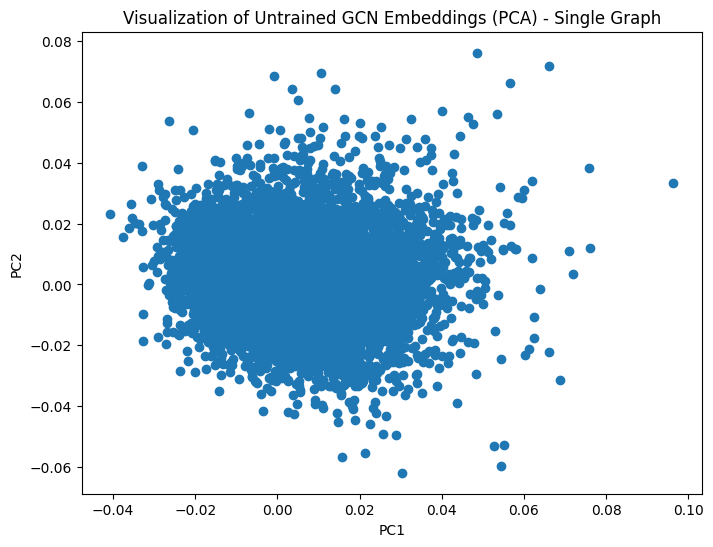

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load data features and edge index (assuming you have them stored)
x = data.x  # Your node features with shape [19717, 500]
edge_index =  data.edge_index # Your edge index with shape [2, 88648]

with torch.no_grad():
    node_embeddings = model.forward(x, edge_index)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_data = pca.fit_transform(node_embeddings.cpu().numpy())

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of Untrained GCN Embeddings (PCA) - Single Graph')
plt.show()


**Perform a grid search hyperparameter tuning for the following parameters:**
- Number of Layers
- Hidden Dimension Size
- Learning Rate
- Dropout Rate
- Batch Size

PS: Remember, first you need to split the data into training, validation and test sets.

In [ ]:
import numpy as np

# Assuming you have your data stored in a variable named 'data'
# 'data' should have the following attributes: x, edge_index, y, train_mask, val_mask, test_mask

# Extract masks
train_mask = data.train_mask.numpy()
val_mask = data.val_mask.numpy()
test_mask = data.test_mask.numpy()

# Convert masks to boolean arrays
train_indices = np.where(train_mask)[0]
val_indices = np.where(val_mask)[0]
test_indices = np.where(test_mask)[0]

# Extract features, labels, and edges
x = data.x.numpy()
y = data.y.numpy()
edge_index = data.edge_index.numpy()

# Split data based on masks
x_train, y_train, edge_index_train = x[train_indices], y[train_indices], edge_index[:, train_indices]
x_val, y_val, edge_index_val = x[val_indices], y[val_indices], edge_index[:, val_indices]
x_test, y_test, edge_index_test = x[test_indices], y[test_indices], edge_index[:, test_indices]

In [ ]:
import itertools

device = torch.device('cuda')
#data = data.to(device)

# Define hyperparameters to search over
num_layers_list = [1, 2, 3]  # Number of layers
hidden_dim_list = [64, 128, 256]  # Hidden dimension size
learning_rate_list = [0.001, 0.01, 0.1]  # Learning rate
dropout_rate_list = [0.0, 0.2, 0.5]  # Dropout rate
batch_size_list = [32, 64, 128]  # Batch size
num_epochs = 100

# Define a function to create and train your model with given hyperparameters
def train_model(num_layers, hidden_dim, learning_rate, dropout_rate, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = GCN(dataset.num_features, hidden_dim=16, num_classes=dataset.num_classes)#.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.NLLLoss()

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        out = model(data.x.to(device), data.edge_index.to(device))
        loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    logits = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(logits[data.val_mask], data.y[data.val_mask].to(device))

    return loss.item(), model


# Initialize variables to store best hyperparameters and loss
best_loss = float('inf')
best_hyperparameters = {}
best_model = None

# Perform grid search
for num_layers, hidden_dim, learning_rate, dropout_rate, batch_size in itertools.product(num_layers_list, hidden_dim_list, learning_rate_list, dropout_rate_list, batch_size_list):
    loss, model = train_model(num_layers, hidden_dim, learning_rate, dropout_rate, batch_size)
    if loss < best_loss:
        best_loss = loss
        best_hyperparameters = {
            'num_layers': num_layers,
            'hidden_dim': hidden_dim,
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size
        }
        best_model = model

# Print best hyperparameters and loss
print("Best hyperparameters:", best_hyperparameters)
print("Best loss:", best_loss)


Best hyperparameters: {'num_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}
Best loss: 0.5605971217155457


**Train the GCN model with the optimal hyperparameters**
 - Select the best model based on the highest validation performance (lowest validation loss).*italicized text*
 - Save the best model to load it later for the final evaluation process.

In [ ]:
# Save the best model
torch.save(best_model.state_dict(), 'best_model.pth')

print("Best model saved successfully.")

Best model saved successfully.


In [ ]:
num_layers= 2
hidden_dim=128
learning_rate= 0.01
dropout_rate=0.5
batch_size= 32

model = GCN(dataset.num_features, hidden_dim=16, num_classes=dataset.num_classes)#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.NLLLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test()

Epoch: 001, Loss: 1.0994
Epoch: 002, Loss: 1.0878
Epoch: 003, Loss: 1.0752
Epoch: 004, Loss: 1.0545
Epoch: 005, Loss: 1.0399
Epoch: 006, Loss: 1.0181
Epoch: 007, Loss: 1.0063
Epoch: 008, Loss: 0.9694
Epoch: 009, Loss: 0.9613
Epoch: 010, Loss: 0.9405
Epoch: 011, Loss: 0.9023
Epoch: 012, Loss: 0.8793
Epoch: 013, Loss: 0.8564
Epoch: 014, Loss: 0.8398
Epoch: 015, Loss: 0.7977
Epoch: 016, Loss: 0.7770
Epoch: 017, Loss: 0.7616
Epoch: 018, Loss: 0.7326
Epoch: 019, Loss: 0.6939
Epoch: 020, Loss: 0.6888
Epoch: 021, Loss: 0.6519
Epoch: 022, Loss: 0.6293
Epoch: 023, Loss: 0.6195
Epoch: 024, Loss: 0.5918
Epoch: 025, Loss: 0.5576
Epoch: 026, Loss: 0.5246
Epoch: 027, Loss: 0.5435
Epoch: 028, Loss: 0.5082
Epoch: 029, Loss: 0.4906
Epoch: 030, Loss: 0.4760
Epoch: 031, Loss: 0.4547
Epoch: 032, Loss: 0.4706
Epoch: 033, Loss: 0.4021
Epoch: 034, Loss: 0.4387
Epoch: 035, Loss: 0.3887
Epoch: 036, Loss: 0.3589
Epoch: 037, Loss: 0.3864
Epoch: 038, Loss: 0.3172
Epoch: 039, Loss: 0.3384
Epoch: 040, Loss: 0.3373


0.76

**Visualize the output embeddings of your trained model. What do you observe?**

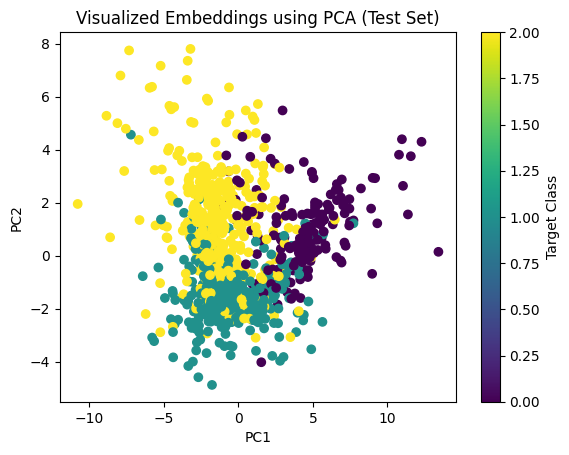

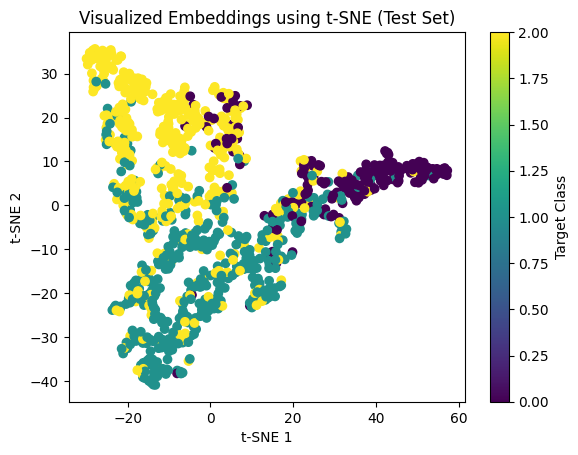

In [ ]:
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE  # Optional for alternative visualization (t-SNE)

# Assuming you have trained your model and it's accessible through `model`

# Get the output embeddings for all nodes in the test set
model.eval()
with torch.no_grad():
    all_embeddings = model(data.x, data.edge_index)  # Get embeddings for all nodes

# Extract embeddings for test nodes only (based on the test mask)
test_embeddings = all_embeddings[data.test_mask]

# Reduce dimensionality using PCA
pca = PCA(n_components=2)  # Reduce to 2D for visualization
pca_reduced = pca.fit_transform(test_embeddings.cpu().numpy())  # Convert to NumPy for PCA

# Visualize the embeddings using a scatter plot
import matplotlib.pyplot as plt

plt.scatter(pca_reduced[:, 0], pca_reduced[:, 1], c=data.y[data.test_mask].cpu().numpy())
plt.colorbar(label='Target Class')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualized Embeddings using PCA (Test Set)')
plt.show()

# Optional: Visualization using t-SNE (might be better for high-dimensional data)
tsne = TSNE(n_components=2)
tsne_reduced = tsne.fit_transform(test_embeddings.cpu().numpy())

plt.scatter(tsne_reduced[:, 0], tsne_reduced[:, 1], c=data.y[data.test_mask].cpu().numpy())
plt.colorbar(label='Target Class')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Visualized Embeddings using t-SNE (Test Set)')
plt.show()


**Evaluate the trained model on the test set and report the classification accuracy**

In [ ]:
print("Classification accuracy : ",test())

Classification accuracy :  0.76
